# Introduction

In this notebook I want to test and compare two types of algorithms: Prophet from Facebook and DNN with LSTM cells.

# Settings

Let's import the required libs first

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection as ms
from tensorflow.keras.preprocessing import sequence
import tensorflow.keras.preprocessing.text as text
import sklearn.metrics as m
import sklearn.preprocessing as pre
import datetime
import sklearn.utils as u
import seaborn as sns
import fbprophet as fbp

In [ ]:
np.random.seed(0)

#for keras.mape:
tf.keras.backend.set_epsilon(1)
mape = tf.keras.losses.MeanAbsolutePercentageError()

# Load and check the data

In [ ]:
df = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv')

In [ ]:
df.head(10)

In [ ]:
df.describe()

In [ ]:
df.date.min(), df.date.max()

So, we have sales information about 50 items in 10 stores from 2013-01-01 to 2017-12-31

## Original data vizualization

In [ ]:
def get_sales_for_store_and_item(df, store, item):
    return df[(df.item == item) & (df.store == store)]

In [ ]:
for i in range(1, 5):
    tmp = get_sales_for_store_and_item(df, 1, i)        
    sns.lineplot(tmp.date, tmp.sales)
plt.show()

# Prophet

Prophet - is a Facebook library which contains the eponymous algorithm for the training  additive regression models. It has three main model components: trend, seasonality, and holidays:

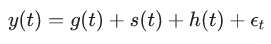 <br> Source: https://peerj.com/preprints/3190/

## Data preparation

I will rename columns how that Prophet requires, set the train/validation date threshold and split the data.

In [ ]:
df_prep_fbp = df
df_prep_fbp = df.rename(columns={"date": "ds", "sales": "y"})

In [ ]:
threshold = '2017-10-03'
df_train_fbp = df_prep_fbp[df_prep_fbp.ds < threshold]
df_valid_fbp = df_prep_fbp[df_prep_fbp.ds >= threshold]

In [ ]:
df_train_fbp.shape, df_valid_fbp.shape

Check are validation and train parts have the same stores and items.

In [ ]:
(df_valid_fbp.item.unique() == df_train_fbp.item.unique()).all()

In [ ]:
(df_valid_fbp.store.unique() == df_train_fbp.store.unique()).all()

## Hyperparameters tuning

Now I will perform grid search of hyperparameters. df contains 10 items and 50 stores but for cross-validation I will use 1 store and 10 items.

Also, I want to note that Prophet isn't like other ML algorithms - we can't just feed all this data in the one estimator, we need to train one estimator per one store and one item, so in total we need to train 500 estimators. This isn't very nice - one estimator will receive only 1/500 of the full data

I have already run hyperparameters tuning related code on my local machine, so I comment out it, but it is valid code.

In [ ]:
# params_grid = {'seasonality_mode': ('multiplicative', 'additive'),
#                'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
#               'holidays_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
#               'n_changepoints' : [100, 150, 200]}
# grid = ms.ParameterGrid(params_grid)

In [ ]:
# df_train_one_store_fbp = df_train_fbp[(df_train_fbp.store == 1)]
# df_valid_one_store_fbp = df_valid_fbp[(df_valid_fbp.store == 1)]

In [ ]:
# model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
# for p in grid:
#     print(p)    
#     param_runs = np.zeros(0)

#     for i in range(1, 11):
#         print(f'Run: {i}')
        
#         df_current_train = df_train_one_store_fbp[(df_train_one_store_fbp.item == i)]
#         df_current_valid = df_valid_one_store_fbp[(df_valid_one_store_fbp.item == i)]


#         train_model = fbp.Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
#                              holidays_prior_scale = p['holidays_prior_scale'],
#                              n_changepoints = p['n_changepoints'],
#                              seasonality_mode = p['seasonality_mode'],
#                              weekly_seasonality=True,
#                              daily_seasonality = True,
#                              yearly_seasonality = True,
#                              #holidays=holiday, 
#                              interval_width=0.95)


#         train_model.add_country_holidays(country_name='US')
#         train_model.fit(df_current_train[['ds', 'y']])
#         train_forecast = train_model.predict(df_current_valid[['ds']])

#         param_runs = np.append(param_runs, mape(df_current_valid.y, train_forecast.yhat))
        
#     MAPE = param_runs.mean()
#     print(f'Mean Absolute Percentage Error: {MAPE}')
#     model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

Here are the best hyperparameters and its MAPE:

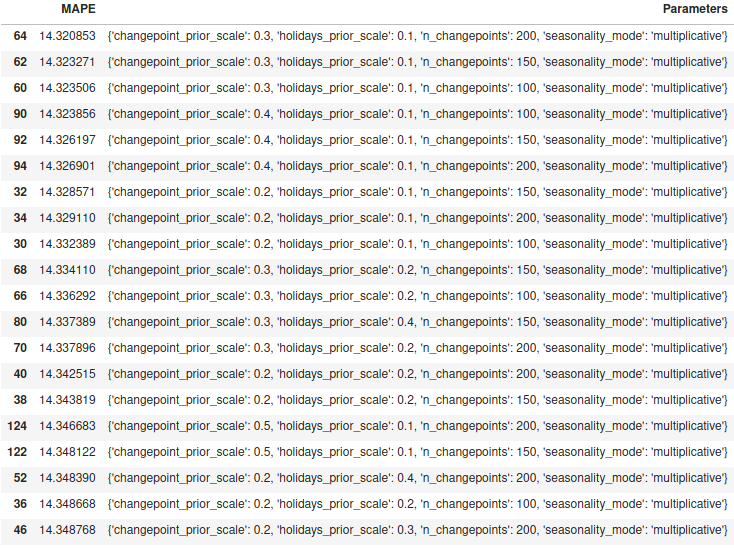

So, hyperparameters 'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative' can give MAPE = 14.3208.

Now let's look what LSTM can do.

# LSTM 

Long short-term memory - is a type of RNN which besides short-term memory(lower from cell-to-cell arrow on the picture) has long-term memory(upper arrow):

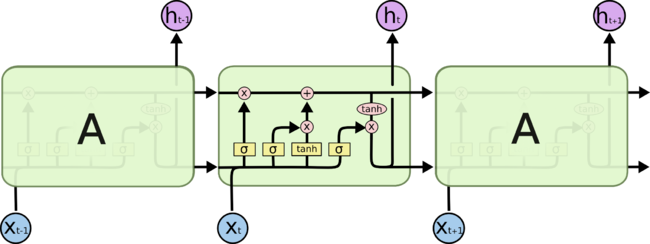 <br> Source: http://neerc.ifmo.ru/wiki/index.php?title=%D0%94%D0%BE%D0%BB%D0%B3%D0%B0%D1%8F_%D0%BA%D1%80%D0%B0%D1%82%D0%BA%D0%BE%D1%81%D1%80%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D0%BF%D0%B0%D0%BC%D1%8F%D1%82%D1%8C

## Data preparation

First of all, we need to prepare data for our DNN. And this is not as easy as with the data for Prophet - now we need to split the data on the features(X) and target(y). So, how can we do this with time series? Well, we can use sales values from one year as features and next 90 days as target. Let's do this!

In [ ]:
def features_target_split(dataset, history_size, target_size):
    features = []
    target = []

    start_index = history_size
    end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        
        features_to_append = dataset[indices]
        features.append(np.reshape(features_to_append, (len(features_to_append), 1)))
        target.append(dataset[i:i+target_size])

    return np.array(features), np.array(target)

I will also define a function for the test data without target part:

In [ ]:
def features_split(dataset, history_size):
    features = []
    features_to_append = dataset[-history_size:]
    features.append(np.reshape(features_to_append, (len(features_to_append), 1)))
    return np.array(features)

I also want to use information about store and item in the our DNN, so I will add X2 features which will contain this info.

Now, let's use the defined above function and split the data.

Note! It's very important to split the data on train/validation parts using data threshold, not sklearn.model_selection.train_test_split(), because train_test_split will shuffle the data, thus the same dates can be in the train and validation parts.

In [ ]:
history_size = 360
target_size = 90
second_features_size = 2

X_train_dnn = np.zeros((0, history_size, 1))
X2_train_dnn = np.zeros((0, second_features_size))
y_train_dnn = np.zeros((0, target_size))

X_valid_dnn = np.zeros((0, history_size, 1))
X2_valid_dnn = np.zeros((0, second_features_size))
y_valid_dnn = np.zeros((0, target_size))

for s in range(1, df.store.max()+1):
    for i in range(1, df.item.max()+1):

        t = df[(df.store == s) & (df.item == i)]

        train_temp = t[t.date < threshold]
        valid_temp = t[t.date >= threshold]


        x_temp_train, y_temp_train = features_target_split(train_temp.sales.values, history_size, target_size)


        x_temp_valid = train_temp.sales.tail(history_size).values
        x_temp_valid = np.reshape(x_temp_valid, (1, history_size, 1))

        y_temp_valid = np.reshape(valid_temp.sales.values, (1, target_size))


        x2_temp_train = np.repeat(np.array([[s, i]]), repeats=x_temp_train.shape[0], axis=0)
        x2_temp_valid = np.repeat(np.array([[s, i]]), repeats=x_temp_valid.shape[0], axis=0)


        X_train_dnn = np.concatenate((X_train_dnn, x_temp_train))
        X_valid_dnn = np.concatenate((X_valid_dnn, x_temp_valid))

        X2_train_dnn = np.concatenate((X2_train_dnn, x2_temp_train), axis=0)
        X2_valid_dnn = np.concatenate((X2_valid_dnn, x2_temp_valid), axis=0)

        y_train_dnn = np.concatenate((y_train_dnn, y_temp_train))
        y_valid_dnn = np.concatenate((y_valid_dnn, y_temp_valid))
        

It's also imporant to visually check that features consistent to the target.

Here is the example of inconsistent features and target - please look at the indexes:

In [ ]:
plt.plot(X_valid_dnn[0])
plt.plot(np.concatenate((np.zeros((history_size)), y_valid_dnn[1])))
plt.show()

Now we need to check is our splitting code works well:

In [ ]:
for i in range(5):
    plt.plot(X_valid_dnn[i])
    plt.plot(np.concatenate((np.zeros((history_size)), y_valid_dnn[i])))
    plt.show()

Looks right, now we can go further.

## CNN-LSTM

I also want to use not just simple LSTM, but CNN-LSTM. As you can guess, this is hybrid of the CNN and LSTM and it initially uses kernels as CNN does to get the features and then pass them to the plain LSTM.

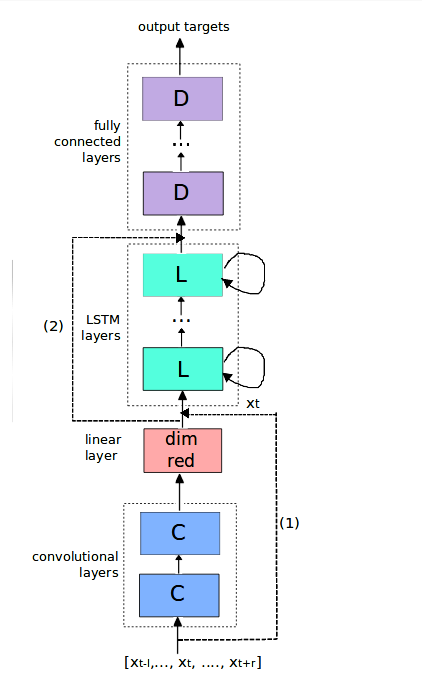 <br> Source: https://www.quora.com/How-does-the-CNN-LSTM-model-work

I want to use it because I think that DNN can get some improvements using this - maybe it will find some patterns in the time series.

And now I need to additionally prepare the X data for the CNN-LSTM

In [ ]:
n_features = 1
n_seq = 4
n_steps = 90

X_train_reshaped_dnn = X_train_dnn.reshape((X_train_dnn.shape[0], n_seq, 1, n_steps, n_features))
X_valid_reshaped_dnn = X_valid_dnn.reshape((X_valid_dnn.shape[0], n_seq, 1, n_steps, n_features))

X_train_reshaped_dnn.shape, X_valid_reshaped_dnn.shape

Also, it's better to convert X2 data to the one-hot representation

In [ ]:
one_hot_encoder = pre.OneHotEncoder(sparse=False, handle_unknown='ignore')
X2_train_dnn = pd.DataFrame(one_hot_encoder.fit_transform(X2_train_dnn))
X2_valid_dnn = pd.DataFrame(one_hot_encoder.transform(X2_valid_dnn))

Now we are ready to shuffle the data

In [ ]:
X_train_dnn_final, X2_train_dnn_final, y_train_dnn_final = u.shuffle(X_train_reshaped_dnn, X2_train_dnn, y_train_dnn)

In [ ]:
X_valid_dnn_final, X2_valid_dnn_final, y_valid_dnn_final = u.shuffle(X_valid_reshaped_dnn, X2_valid_dnn, y_valid_dnn)

In [ ]:
BATCH_SIZE = 500

x_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_dnn_final, X2_train_dnn_final))
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train_dnn_final)
train_dataset = tf.data.Dataset.zip((x_train_dataset, y_train_dataset))
train_dataset = train_dataset.cache().shuffle(X_train_dnn.shape[0]).batch(BATCH_SIZE).repeat()

x_val_dataset = tf.data.Dataset.from_tensor_slices((X_valid_dnn_final, X2_valid_dnn_final))
y_val_dataset = tf.data.Dataset.from_tensor_slices(y_valid_dnn_final)

val_dataset = tf.data.Dataset.zip((x_val_dataset, y_val_dataset))
val_dataset = val_dataset.batch(BATCH_SIZE).repeat()

## Keras Functional API

Before the DNN hyperparameters search I want to explain how we can feed mixed data(X which are time series and X2 which are one-hot features) in the our model. For this I will use Keras Functional API which is the way how we can build non-linear graphs of layers in Keras. So, instead of stacking layers one on other as we can do with the Sequential API, with Functional API we can build almost any non-cyclic graph. In this API one layer can receive previous layer as function can receive its parameter, here is an example:

In [ ]:
# i = tf.keras.layers.Input(shape=(3,))
# h = tf.keras.layers.Dense(units=3, activation='relu')(i)
# o = tf.keras.layers.Dense(units=1)(h)
# model = tf.keras.models.Model(inputs=i, outputs=o)

So, using this we can simply create two inputs, separately process the data from them, and merge outputs of the layers into the one layer.

## Hyperparameters tuning

Now we come to the hardest and longest part :) For the hyperparameters tuning I used auto and manual random search on the multiple machines. There have been many attempts and a lot of code for them, so I'll only leave one part that shows what part of this process looked like. And I also will comment out it, but it is valid.

In [ ]:
# DROPOUT = hp.HParam('dropout', hp.Discrete([0.10, 0.15, 0.20]))
# KERNEL2_SIZE = hp.HParam('kernel2_size', hp.Discrete([2, 3]))
# LAYER_WITH_512 = hp.HParam('layer_with_512', hp.Discrete([0, 1, 2]))
# THIRD_LAYER = hp.HParam('third_layer', hp.Discrete([False, True]))

In [ ]:
# METRIC_MAPE = 'mape'

In [ ]:
# with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
#     hp.hparams_config(
#         hparams=[DROPOUT, KERNEL2_SIZE, LAYER_WITH_512, THIRD_LAYER],
#         metrics=[hp.Metric(METRIC_MAPE, display_name=METRIC_MAPE)],
#     )

In [ ]:
# def train_val_model(hparams):
    
#     filters_1 = 512 if hparams[LAYER_WITH_512] == 1 else 256
#     filters_2 = 512 if hparams[LAYER_WITH_512] == 2 else 256

#     i1 = tf.keras.layers.Input(shape=(n_seq, 1, n_steps, n_features))
#     tsl = tf.keras.layers.ConvLSTM2D(filters=filters_1, recurrent_dropout=hparams[DROPOUT], padding='same', return_sequences=True,  kernel_size=(1,hparams[KERNEL2_SIZE]), activation='relu')(i1)
#     tsl = tf.keras.layers.BatchNormalization()(tsl)
#     tsl = tf.keras.layers.Dropout(hparams[DROPOUT])(tsl)

#     tsl = tf.keras.layers.ConvLSTM2D(filters=filters_2, recurrent_dropout=hparams[DROPOUT], padding='same', return_sequences=True, kernel_size=(1,hparams[KERNEL2_SIZE]), activation='relu')(tsl)
#     tsl = tf.keras.layers.BatchNormalization()(tsl)
#     tsl = tf.keras.layers.Dropout(hparams[DROPOUT])(tsl)
    
#     if hparams[THIRD_LAYER]:
#         tsl = tf.keras.layers.ConvLSTM2D(filters=filters_2, recurrent_dropout=hparams[DROPOUT], kernel_size=(1,hparams[KERNEL2_SIZE]), activation='relu')(tsl)
#         tsl = tf.keras.layers.BatchNormalization()(tsl)
#         tsl = tf.keras.layers.Dropout(hparams[DROPOUT])(tsl)
    
#     fl1 = tf.keras.layers.Flatten()(tsl)

#     i2 = tf.keras.layers.Input(shape=(X2_train_dnn.shape[1]))
#     ohl = tf.keras.layers.Dense(units=10, activation='relu')(i2)

#     merge = tf.keras.layers.concatenate([fl1, ohl])

#     d = tf.keras.layers.Dense(units=150, activation='relu')(merge)
#     o = tf.keras.layers.Dense(90)(d)

#     model = tf.keras.models.Model(inputs=[i1, i2], outputs=o)

#     adam = tf.keras.optimizers.Adam(learning_rate=0.001)
#     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.00001)

#     model.compile(optimizer=adam, loss='mape')

#     EVALUATION_INTERVAL = 200
#     EPOCHS = 40

#     logdir = ("logs/cv/" +  
#     'DR-' + str(hparams[DROPOUT]) + '.' + 
#     'K2S-' + str(hparams[KERNEL2_SIZE]) + '.' +
#     'LW512-' + str(hparams[LAYER_WITH_512]) + '.' +
#     '3L-' + str(hparams[THIRD_LAYER])
#     )

#     tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    
#     model.fit(train_dataset, epochs=EPOCHS, callbacks=[reduce_lr, tensorboard_callback],
#                       steps_per_epoch=EVALUATION_INTERVAL,
#                       verbose=2,
#                       validation_data=val_dataset, validation_steps=75)

#     l = model.evaluate(val_univariate, steps=75)

#     return l

In [ ]:
# def run(run_dir, hparams):
#     with tf.summary.create_file_writer(run_dir).as_default():
#         hp.hparams(hparams)
#         res = train_val_model(hparams)
#         tf.summary.scalar(METRIC_MAPE, res, step=1)

In [ ]:
# session_num = 0
# start = time.perf_counter()

# total_models = (
# len(DROPOUT.domain.values) 
# * len(LAYER_WITH_512.domain.values)
# * len(KERNEL2_SIZE.domain.values)
# * len(THIRD_LAYER.domain.values)
# )

# for dropout in DROPOUT.domain.values:
#     for layer_with_512 in LAYER_WITH_512.domain.values:
#         for kernel2_size in KERNEL2_SIZE.domain.values:
#             for third_layer in THIRD_LAYER.domain.values:

#                 hparams = {
#                     DROPOUT: dropout,
#                     LAYER_WITH_512: layer_with_512,
#                     KERNEL2_SIZE: kernel2_size,
#                     THIRD_LAYER: third_layer,
#                 }
#                 run_name = "run-%d" % session_num
#                 print('--- Starting trial: %s' % run_name)
#                 print({h.name: hparams[h] for h in hparams})
#                 run('logs/hparam_tuning/' + run_name, hparams)

#                 elapsed = (time.perf_counter() - start) / 60.0
#                 print('Elapsed from start %.3f minutes.' % elapsed)

#                 session_num += 1

# pbar.close()

Here are top 3 result:

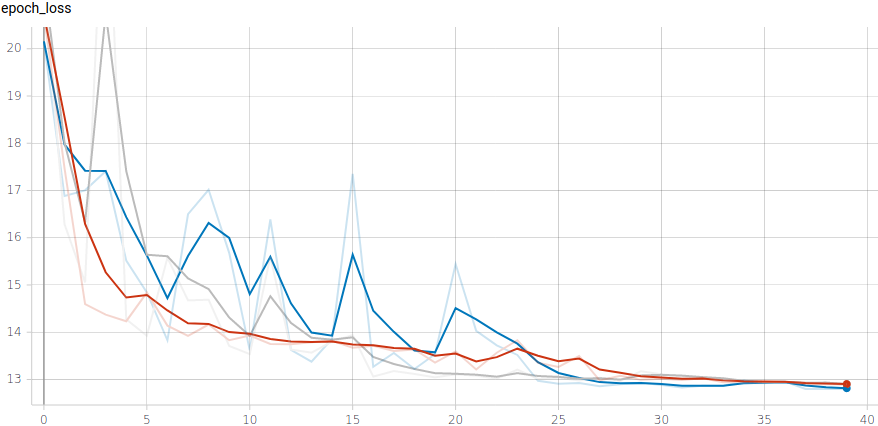

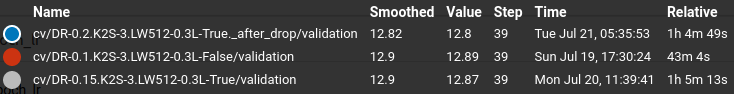

But after that and a few other hyperparameters test runs I manually tested some other net versions which worked slightly better, so I will use a little bit different architecture for the final model.

I also want to show some interesting thing. Here is the another run:

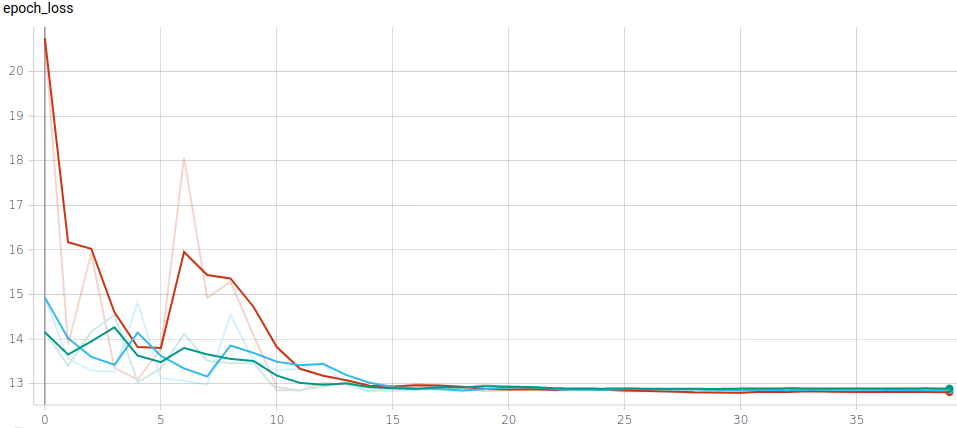

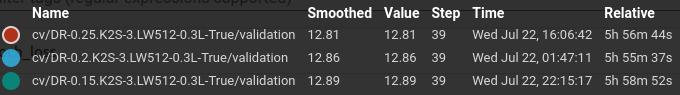

And as you can see, the bigger dropout, the bigger validation loss fluctuations, but the smaller loss in the end. Interesting, notice this.

# Comparing Prophet and DNN

## Mape

We have best Prophet MAPE loss = 14.32, and best DNN MAPE loss = 12.82. So, we will use the DNN model as the final model.

## Pros and cons

I think it's unfair to compare only losses, so here are the pros of these two algorithms:

Prophet: <br> - Very easy and intuitive to use <br> - Need small amount of data for the good results <br> - Fast training <br> - Hyperparameters tuning is also fast and straightforward

DNN with LSTM cells: <br> - Very flexible <br> - Any input, not only time series <br> - Many hyperparameters to tune <br> - Smaller loss

# Model finalization

Now let's train the final model.

In [ ]:
model_name = 'model.h5'
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name, save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
DROPOUT = 0.35

In [ ]:
i1 = tf.keras.layers.Input(shape=(n_seq, 1, n_steps, n_features))
tsl = tf.keras.layers.ConvLSTM2D(filters=256, recurrent_dropout=DROPOUT, padding='same', return_sequences=True,  kernel_size=(1,3), activation='relu')(i1)
tsl = tf.keras.layers.BatchNormalization()(tsl)
tsl = tf.keras.layers.Dropout(DROPOUT)(tsl)

tsl = tf.keras.layers.ConvLSTM2D(filters=256, recurrent_dropout=DROPOUT, padding='same', return_sequences=True,  kernel_size=(1,3), activation='relu')(i1)
tsl = tf.keras.layers.BatchNormalization()(tsl)
tsl = tf.keras.layers.Dropout(DROPOUT)(tsl)

tsl = tf.keras.layers.ConvLSTM2D(filters=256, recurrent_dropout=DROPOUT, kernel_size=(1,3), activation='relu')(tsl)
tsl = tf.keras.layers.BatchNormalization()(tsl)
tsl = tf.keras.layers.Dropout(DROPOUT)(tsl)
fl1 = tf.keras.layers.Flatten()(tsl)

i2 = tf.keras.layers.Input(shape=(X2_train_dnn.shape[1]))
ohl = tf.keras.layers.Dense(units=10, activation='relu')(i2)

merge = tf.keras.layers.concatenate([fl1, ohl])

d = tf.keras.layers.Dense(units=150, activation='relu')(merge)
o = tf.keras.layers.Dense(90)(d)

final_model = tf.keras.models.Model(inputs=[i1, i2], outputs=o)

final_model.compile(optimizer=adam, loss='mape')

In [ ]:
final_model.summary()

In [ ]:
EVALUATION_INTERVAL = 600
EPOCHS = 50

history = final_model.fit(train_dataset, 
                epochs=EPOCHS, 
                callbacks=[reduce_lr_cb, model_checkpoint_cb],
                steps_per_epoch=EVALUATION_INTERVAL, 
                verbose=1,
                validation_data=val_dataset, validation_steps=100)

In [ ]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
plot_history(history)

In [ ]:
model = tf.keras.models.load_model(model_name)
model.evaluate(val_dataset, steps=100)

# Predicting

In [ ]:
y_pred = pd.DataFrame()
for i in range(1, df.item.max()+1):
    for s in range(1, df.store.max()+1):
        t = df[(df.store == s) & (df.item == i)]

        x_t = features_split(t.sales.values, history_size)
        x_t = x_t.reshape((x_t.shape[0], n_seq, 1, n_steps, n_features))

        x2_t = np.array([[s, i]])
        x2_t = pd.DataFrame(one_hot_encoder.transform(x2_t))

        y_t = pd.DataFrame()
        y_t['sales'] = model.predict([x_t, x2_t]).reshape((-1))
        y_pred = y_pred.append(y_t, ignore_index=True)

y_pred['Id'] = y_pred.index
y_pred

In [ ]:
y_pred.to_csv("submission.csv", index=False)

# Conclusion

We have successfully compared Prophet algorithm and DNN with CNN-LSTM cells. I chose LSTM because it gives smaller loss. Unfortunately this model still experiences validation loss fluctuations, but it gives fine test results and this is the main thing :)